# AI-text-detector

Improve with following link:
* https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb#scrollTo=eXNLu_-nIrJI

In [15]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, XLMRobertaXLModel
import torch
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# optim
import torch.optim as optim

In [16]:
(3).__add__(4) 
 

7

## Training

In [20]:
# load texts and labels
def text_edit(text):
    # remove first two lines
    text = '\n'.join(text.split('\n')[2:])

    # cut longer than 2000 characters
    text = text[:2000]

    # # remove everything After Kilde:
    # text = text.split('Kilde:')[0]

    # remove empty lines
    # text = '\n'.join([line for line in text.split('\n') if line != ''])

    # remove new lines
    # text = ' '.join(text.split('\n'))

    # remove double spaces
    # text = ' '.join(text.split('  '))

    # remove emojis
    # text = text.encode('ascii', 'ignore').decode('ascii')
   

    # Assuming 'text' is defined and contains sentences
    # sentences = text.split('.')
    # num_sentences = len(sentences)
    # if num_sentences > 4:

    #     # Create an exponential distribution for probabilities
    #     # The exponential distribution should favor lower indices for rand_low and higher indices for rand_high
    #     probabilities = np.exp(np.linspace(0, 2, num_sentences-1))
    #     probabilities /= probabilities.sum()  # Normalize to make it a valid probability distribution

    #     # Choose rand_low and rand_high using the defined probabilities
    #     rand_low = np.random.choice(np.arange(num_sentences-1), p=probabilities[::-1])
    #     rand_high = np.random.choice(np.arange(rand_low+1, num_sentences), 
    #                     p=probabilities[rand_low:] / probabilities[rand_low:].sum())

    #     # Join the selected range of sentences
    #     text = '.'.join(sentences[rand_low:rand_high])

    cuts = []
    sentences = text.split('. ')
    num_sentences = len(sentences)
    cuts.append(text)
    # if we have for example 12 setences, we want to cut it into 3 pieces
    # num_cuts = num_sentences // 4

    # for i in range(num_cuts):
    #     cuts.append('. '.join(sentences[i*4:(i+1)*4]))
        

    return cuts

def load_data():

    import os

    data = {
        'human': [],
        'bot': []
    }

    data_sources = {
        'human' : ['data/heste-nettet-nyheder/',
                   'data/from_big_data_file/'][::-1],
        'bot' : ['data/heste-nettet-nyheder-ai/gpt-3.5-turbo/', 
                 'data/heste-nettet-nyheder-ai/gpt-4-0613/', 
                 'data/from_big_data_file_ai/gpt-3.5-turbo/', 
                 'data/from_big_data_file_ai/gpt-3.5-turbo-0613/'][::-1],
    }

    for source in data_sources:
        for path in data_sources[source]:
            for filename in os.listdir(path):
                with open(path + filename, 'r', encoding='utf-8') as f:
                    content = f.read()
                    cuts = text_edit(content)
                    for text in cuts:
                        data[source].append(text)

    # cut to same length
    min_len = min(len(data['human']), len(data['bot']))
    data['human'] = data['human'][:min_len]
    data['bot'] = data['bot'][:min_len]
    
    my_texts = np.array(data['human'] + data['bot'])
    my_labels = np.array([0]*len(data['human']) + [1]*len(data['bot'])) 

    return list(my_texts), my_labels

def preprocess(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    return inputs

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.inputs = preprocess(texts)

        # dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
        self.input_ids = self.inputs['input_ids']
        self.attention_mask = self.inputs['attention_mask']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]

        return {
            # 'text': text,
            'label': label,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }


# Assume you're using a GPU for training
device = torch.device("mps" if torch.has_mps else "cpu")
print("Using device:", device)

###### SELECT MODEL ######
model_name = "bert-base-multilingual-cased"  # or another model suitable for Danish
local_model = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name, use_fast=True )
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = XLMRobertaXLModel.from_pretrained(model_name)




texts, labels = load_data()
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2)

dataset_train = TextDataset(texts_train, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)

dataset_test = TextDataset(texts_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=True)


# print table summary with total samples in each dataset, positive samples, and negative samples
def pretty_print_info_table(labels_train, labels_test):
    data_for_table = {
        'train': {
            'total': len(labels_train),
            'pos': np.sum(labels_train),
            'neg': len(labels_train) - np.sum(labels_train)
        },
        'test': {
            'total': len(labels_test),
            'pos': np.sum(labels_test),
            'neg': len(labels_test) - np.sum(labels_test)
        }
    }
    data_for_table['total'] = {
        'total': data_for_table['train']['total'] + data_for_table['test']['total'],
        'pos': data_for_table['train']['pos'] + data_for_table['test']['pos'],
        'neg': data_for_table['train']['neg'] + data_for_table['test']['neg']
    }

    print("""
    Info table:
    +----------------+---------+---------+-------+
    |                | Training| Testing | Total
    +----------------+---------+---------+-------+
    | Total samples  | {:7d} | {:7d} | {:7d} |
    | Pos. samples   | {:7d} | {:7d} | {:7d} |  (AI generated)
    | Neg. samples   | {:7d} | {:7d} | {:7d} |  (Human written)
    """.format(
        data_for_table['train']['total'],
        data_for_table['test']['total'],
        data_for_table['total']['total'],
        data_for_table['train']['pos'],
        data_for_table['test']['pos'],
        data_for_table['total']['pos'],
        data_for_table['train']['neg'],
        data_for_table['test']['neg'],
        data_for_table['total']['neg'],
        
        ))

pretty_print_info_table(labels_train, labels_test)

# weight for positive class
weight_pos = len(texts_train) / (2 * np.sum(labels_train))
# weight for negative class
weight_neg = len(texts_train) / (2 * (len(texts_train) - np.sum(labels_train)))
# class weights
class_weights = torch.tensor([weight_neg, weight_pos])

# the class weights are defined, but im unsure how to apply them as the loss function is incooperated in the forward pass of the model, so i will just balance the dataset instead.


Using device: mps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



    Info table:
    +----------------+---------+---------+-------+
    |                | Training| Testing | Total
    +----------------+---------+---------+-------+
    | Total samples  |    7528 |    1882 |    9410 |
    | Pos. samples   |    3790 |     915 |    4705 |  (AI generated)
    | Neg. samples   |    3738 |     967 |    4705 |  (Human written)
    


In [21]:

model.to(device)

# freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


# Training loop
from transformers import AdamW
lr = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, )

# early stopping
def early_stopping(losses, patience=10):
    if len(losses) < patience:
        return False
    return losses[-1] > max(losses[-patience:-1])

losses = {'train': [], 'test': []}
num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    # Train
    loss_total_train = 0
    for i, batch in enumerate(dataloader_train):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)


        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        #rint(outputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        loss_total_train += loss.item()

    print(f"Epoch {epoch} loss: {loss_total_train / len(dataset_train)}")
    losses['train'].append(loss_total_train / len(dataset_train))

    # Test
    model.eval()
    loss_total_test = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader_test):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss_total_test += loss.item()

    print(f"Epoch {epoch} test loss: {loss_total_test / len(dataset_test)}")
    losses['test'].append(loss_total_test / len(dataset_test))

    # if validation loss is lowest, save model
    if min(losses['test']) == losses['test'][-1]:
        model.save_pretrained("models/bert_classifier", save_function=torch.save)
        print("Model saved")

    if early_stopping(losses['test']):
        print("Early stopping")
        break

    




Epoch 0 loss: 0.03120507074640737
Epoch 0 test loss: 0.02287422263090213
Model saved
Epoch 1 loss: 0.02162667529956377
Epoch 1 test loss: 0.017661590386463148
Model saved
Epoch 2 loss: 0.01841519223714166
Epoch 2 test loss: 0.015484453130446128
Model saved
Epoch 3 loss: 0.016841522080469462
Epoch 3 test loss: 0.014276565823557526
Model saved
Epoch 4 loss: 0.015538662250423912
Epoch 4 test loss: 0.013066284372357455
Model saved
Epoch 5 loss: 0.014961849509636445
Epoch 5 test loss: 0.012336686772158751
Model saved
Epoch 6 loss: 0.013977874268349122
Epoch 6 test loss: 0.012994883370196782
Epoch 7 loss: 0.014059050111585038
Epoch 7 test loss: 0.011520604974135963
Model saved
Epoch 8 loss: 0.013736762153924968
Epoch 8 test loss: 0.012569258969344445
Epoch 9 loss: 0.013129564763247713
Epoch 9 test loss: 0.011348769444809963
Model saved
Epoch 10 loss: 0.013392686669682088
Epoch 10 test loss: 0.0108041719223722
Model saved
Epoch 11 loss: 0.012749687441912709
Epoch 11 test loss: 0.0109866112589

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

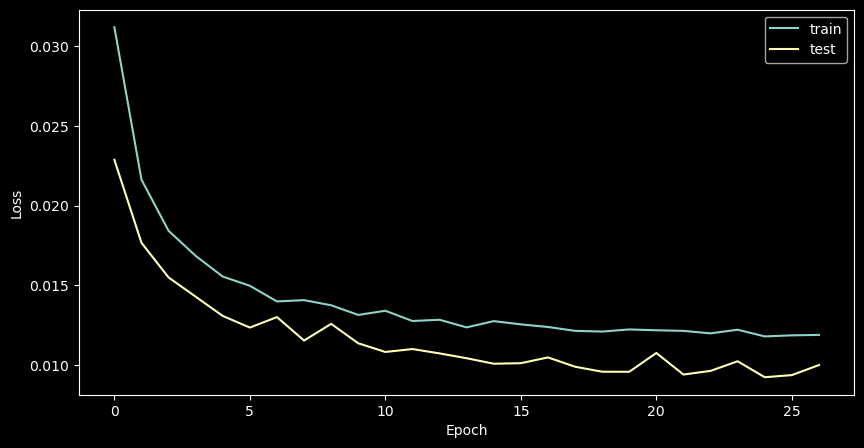

In [22]:
# load model
model = BertForSequenceClassification.from_pretrained("models/bert_classifier")
plt.style.use('dark_background')

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses['train'], label='train')
plt.plot(losses['test'], label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
# set background to black



## Model Validation

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       967
           1       0.93      0.97      0.95       915

    accuracy                           0.95      1882
   macro avg       0.95      0.95      0.95      1882
weighted avg       0.95      0.95      0.95      1882



Text(0.5, 1.0, 'Confusion matrix for BERT detector, for detecting AI generated texts')

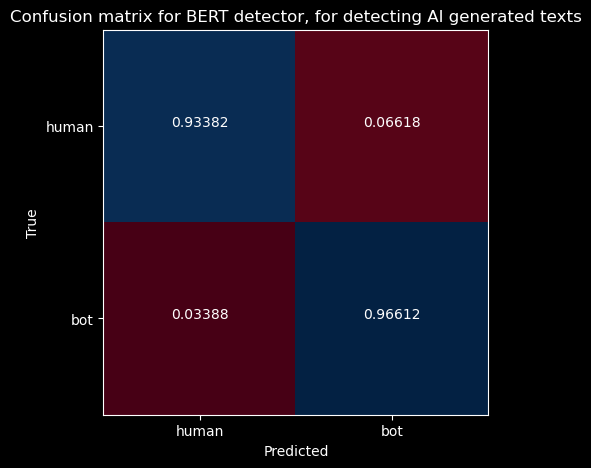

In [23]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

model.to(device)

model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for i, batch in enumerate(dataloader_test):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions))

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap=plt.cm.RdBu, alpha=.7 )

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, "{:.5f}".format(cm[i, j]), horizontalalignment="center")

plt.xticks([0, 1], ['human', 'bot'])
plt.yticks([0, 1], ['human', 'bot'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix for BERT detector, for detecting AI generated texts")

## Model Application

In [24]:
# load my model
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("models/bert_classifier")
model.to(device);

In [25]:
# test
test_string = "This is a test"

model.eval()    
with torch.no_grad():
    inputs = preprocess(test_string)
    input_ids = inputs['input_ids'].squeeze(1).to(device)
    attention_mask = inputs['attention_mask'].squeeze(1).to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    print(logits)
    print(torch.argmax(logits).item())

tensor([[ 3.7680, -3.9610]], device='mps:0')
0


## Ftitting it into router format

In [26]:
# to fit into the pipeline i need to make a predict function

def predict(text):
    model.eval()    
    with torch.no_grad():
        inputs = preprocess(text)
        input_ids = inputs['input_ids'].squeeze(1).to(device)
        attention_mask = inputs['attention_mask'].squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        return torch.argmax(logits).item()

def predict_batches(texts, batch_size=256, device='cpu'):
    dataset = TextDataset(texts, [0]*len(texts))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.to(device)
    model.eval()  
    predictions = []  
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(logits.argmax(dim=1).cpu().numpy())

    return predictions

# test
test_string = "This is a test"
print(predict(test_string))

0


## Test on data.csv

In [27]:
import pandas as pd
df = pd.read_csv('data.csv')
df

df['bert_prediction'] = df['text'].apply(predict)

df

,text,is_generated,bert_prediction
0,"Det gør firmaerne, der står bag AI'en - eksemp...",0,0
1,"Tror det bliver for kedeligt, hvis vi bare læs...",0,0
2,"Godt spørgsmål! Det er nemlig meget, meget svæ...",0,1
3,"Ja, det er begyndt at ske. Det er dog ikke så ...",1,1
4,Det vil jeg tro - uden at vide det helt præcis...,0,1
5,"Selvom det er svært at forudsige, hvornår AI v...",1,1
6,"Det afhænger nok meget af, hvor fremme i skoen...",0,0
7,"En tech-korrespondent er en journalist, der dæ...",1,1
8,"ChatGPT er en generativ AI-model, der lærer at...",1,1
9,"Hej, den har læst en masse tekst og så regner ...",0,1


## Test on val.csv

In [28]:
pd.read_csv('data/val.csv', index_col=0)

,0
0,"I min optik er god forskning det samme som ""st..."
1,"Jeg synes, der er rigtig gode erstatninger på ..."
2,"Selvom der er tale om en sag, der har været i ..."
3,"Vi er ikke i en storkonflikt lige nu, men det ..."
4,Ja! Det er helt horribelt at der fortsat sidde...
...,...
1128,"Ja, det er blevet rapporteret, at Rusland står..."
1129,"Ja, der er tale om en domsmandssag, hvor der e..."
1130,Vi er sociale liberale - det er ikke at man er...
1131,"I klubberne er der også fokus på præstation, o..."


In [29]:

df = pd.read_csv('data/val.csv')
import time
#df['bert_prediction'] = df['text'].apply(predict)
run_times = {}
for bs in np.linspace(30, 120, 4):
    bs = int(bs)
    start = time.time()
    df['pred'] = predict_batches(df['0'].tolist(), batch_size=bs , device='mps')
    end = time.time()
    run_times[bs] = end - start
    print(f"Batch size: {bs}, time: {end - start}")
    break

plt.figure(figsize=(10, 5))

plt.plot(list(run_times.keys()), list(run_times.values()))
plt.xlabel('Batch size')
plt.ylabel('Time (s)')
plt.title('Time to predict with BERT, depending on batch size')
plt.close()


Batch size: 30, time: 34.48276495933533


In [32]:
# save df['pred']
np.savez('bert_predictions.npz', pred=df['pred'].to_numpy())
# load df['pred']
labels = np.load('bert_predictions.npz')
print(sum(labels['pred']))

624


In [ ]:
# run xgboost on dataset_train = TextDataset(texts_train, labels_train)

import xgboost as xgb
from sklearn.metrics import accuracy_score

# make dummy features
def make_dummy_features(texts):
    features = []
    for text in texts:
        features.append([len(text), len(text.split()), len(text.split('\n'))])
    return np.array(features)

features_train = make_dummy_features(texts_train)
features_test = make_dummy_features(texts_test)

labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

# train model (classifier)
model = xgb.XGBClassifier()
model.fit(features_train, labels_train)

# predict
predictions = model.predict(features_test)
print(accuracy_score(labels_test, predictions))


0.96843853820598
